In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from uncertainty_forest.uncertainty_forest import UncertaintyForest

from sklearn import datasets
from tqdm import tqdm_notebook
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def generate_data(n):
    
    # Class sizes.
    n_0 = np.random.binomial(n, 0.5, 1)[0]
    n_1 = n - n_0
    
    # Generate uniform spiral.
    theta = np.random.uniform(0.0, 5*np.pi, size=n_0).reshape(-1, 1) # TODO change to uniform sampling.
    X_0 = np.concatenate((2*np.cos(theta), 2*np.sin(theta), 5*theta / np.pi - 10), axis = 1)
    y_0 = np.repeat(0, n_0)
    
    # Generate fuzzy stick.
    sigma = 0.05
    zeros = np.zeros((n_1, 1))
    X_1 = np.concatenate((zeros, zeros, np.random.uniform(-10, 10, n_1).reshape(-1, 1)), axis = 1)
    X_1 += np.random.multivariate_normal(np.zeros(3), sigma*np.eye(3), n_1)
    y_1 = np.repeat(1, n_1)
    
    X = np.concatenate((X_0, X_1), axis = 0)
    y = np.concatenate((y_0, y_1), axis = 0)                  
    
    return X, y

In [3]:
def split_train_eval(X, y, frac_eval):
    
    if frac_eval == 0:
        return X, y, [], []
    
    n = len(y)
    n_eval = int(np.floor(frac_eval*n))
    eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
    X_eval = X[eval_indices, :]
    y_eval = y[eval_indices]
    X = np.delete(X, eval_indices, axis = 0)
    y = np.delete(y, eval_indices, axis = 0)
    
    return X, y, X_eval, y_eval

In [4]:
def plot_setting(X, y):
    colors = np.array(["#2166ac", "#c51b7d"])

    fig = plt.figure(figsize=(15, 15))
    ax = fig.gca(projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:,2], s=100, c=colors[y], depthshade=True)

    # Remove background.
    # Get rid of colored axes planes
    # First remove fill
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    # ax.grid(False)

    plt.show()

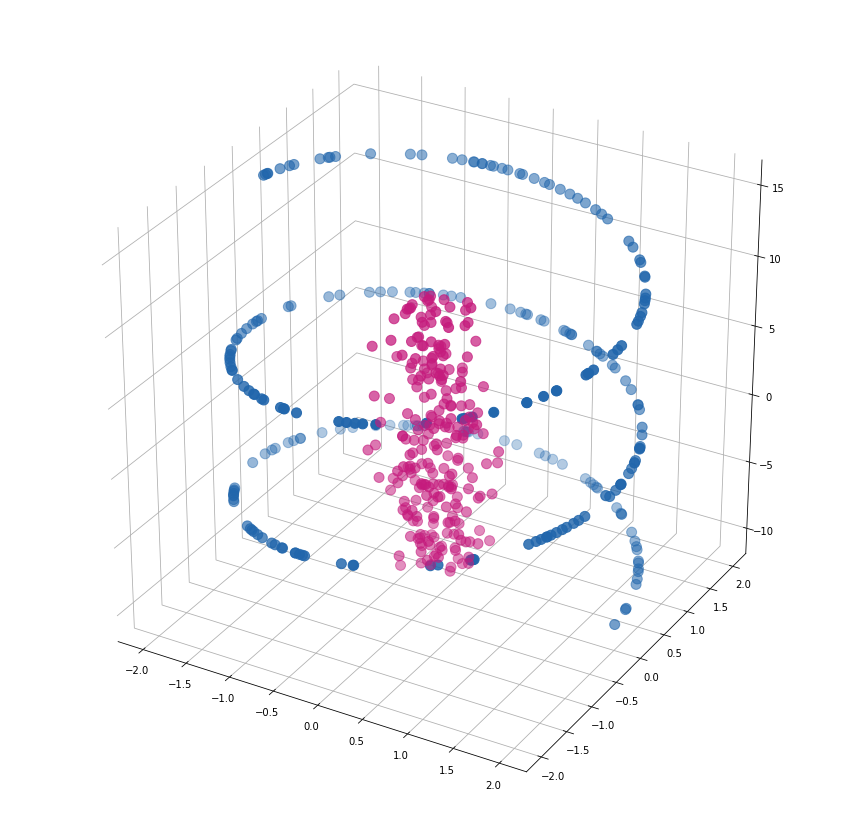

In [5]:
n = 500

X, y = generate_data(n)
plot_setting(X, y)

In [11]:
def mutual_info_dist(n, frac_eval, algos, num_trials, parallel):
    # For each trial, generate data and compute conditional entropy for each algorithm.
    def worker(t):
        X, y = generate_data(n)
        ret = np.zeros(len(algos))
        X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        for j in range(len(algos)):
            obj = algos[j]['instance']
            obj.fit(X, y)
            ret[j] = obj.estimate_mutual_info(X_eval)
        return ret
    
    if parallel:
        predicted_mutual_info = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
    else:
        predicted_mutual_info = np.zeros((num_trials, len(algos)))
        for t in tqdm_notebook(range(num_trials)):
            predicted_mutual_info[t, :] = worker(t)
            
    return predicted_mutual_info

def mutual_info_by_n(sample_sizes, frac_eval, algos, num_trials, parallel = False):
    # Repeat for all 'n', and save output in the 'algos' array.
    mutual_info_range = np.zeros((len(sample_sizes), num_trials, len(algos)))
    for i in range(len(sample_sizes)):
        mutual_info_range[i, :, :] = mutual_info_dist(sample_sizes[i],
                                                      frac_eval, 
                                                      algos, 
                                                      num_trials,
                                                      parallel = parallel)
        
    for j in range(len(algos)):
        algos[j]['mutual_info_by_n'] = mutual_info_range[:, :, j]
        
    with open('algos_fig6.pkl', 'wb') as f:
        pickle.dump(algos, f)
    with open('sample_sizes_fig6.pkl', 'wb') as f:
        pickle.dump(sample_sizes, f)

In [22]:
# Data.
sample_sizes = range(10, 30, 10)
num_trials = 3
frac_eval = 0.3

# Algorithms.
algos = [
#     {
#         'instance': RandomForestClassifier(min_samples_leaf = 6, n_estimators = 30),
#         'label': 'KSG',
#         'title': 'KSG',
#         'color': "#1b9e77",
#     },
    {
        'instance': UncertaintyForest(finite_correction = False, n_estimators = 60),
        'label': 'Mixed KSG',
        'title': 'Mixed KSG',
        'color': "#fdae61",
    },
    {
        'instance': UncertaintyForest(n_estimators = 60),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

# Other.
num_plotted_trials = 3
parallel = True

In [23]:
mutual_info_by_n(sample_sizes, frac_eval, algos, num_trials, parallel = parallel)

In [24]:
def plot_mutual_info_by_n(sample_sizes, algos, num_plotted_trials):
    sns.set(font_scale = 1.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    
    fig = plt.figure(figsize=(15, 15))
    ax = fig.gca()
    
    for algo in algos:
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes, 
                np.mean(algo['mutual_info_by_n'], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 2, 
                color = algo['color'])

        # Plot other trials as light lines.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    algo['mutual_info_by_n'][:, t].flatten(),  
                    linewidth = 4, 
                    color = algo['color'],
                    alpha = 0.15)
        ax.set_ylabel("Estimated Mutual Info")

    # plt.ylim(ymin = -.05)
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.xlabel("Sample Size")
    plt.tight_layout()
    plt.savefig("fig6_est.pdf")
    plt.show()

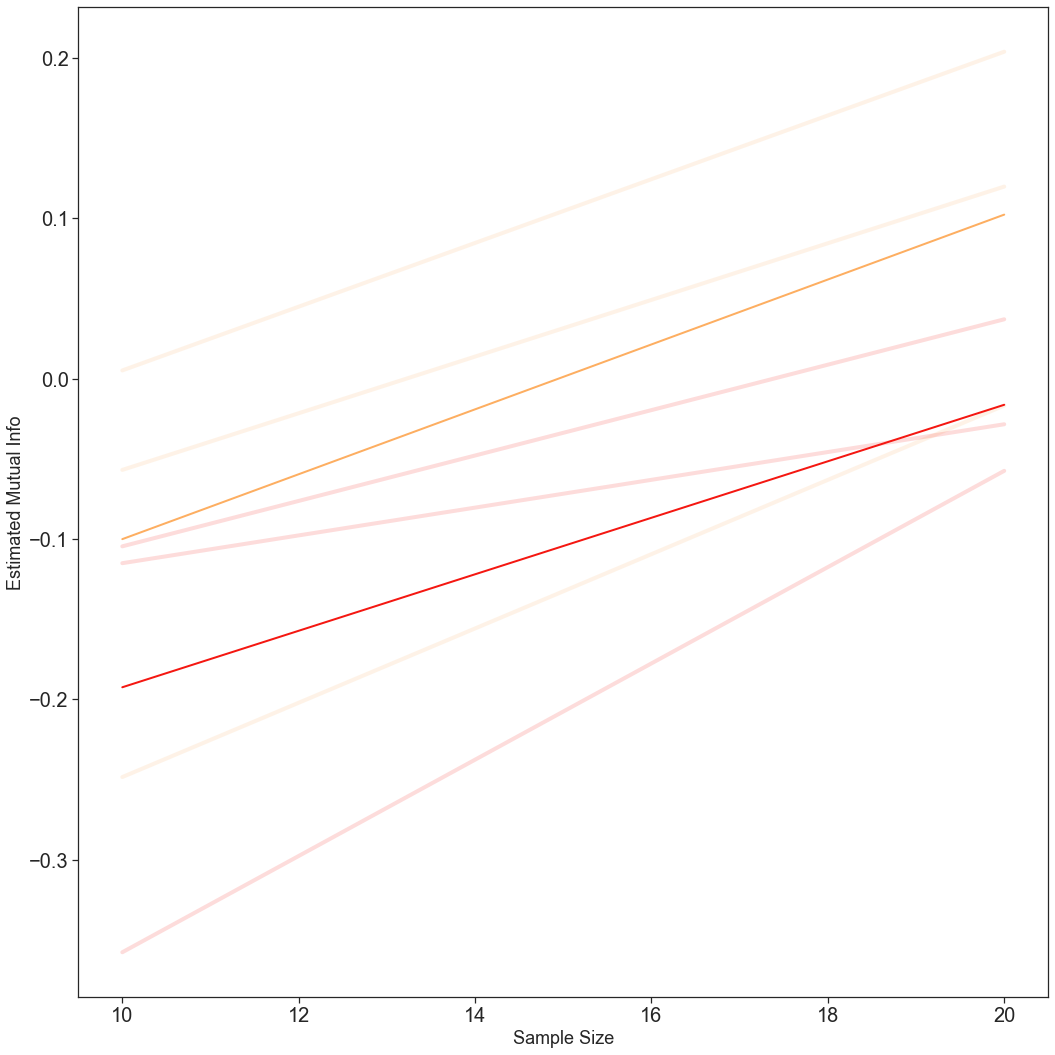

In [25]:
plot_mutual_info_by_n(sample_sizes, algos, num_plotted_trials)